**Author:** [Giuseppe Muschetta](https://github.com/peppe212)
**Python version:** 3.11

# K-Means Prototype-Based Partitional Clustering

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import folium
%matplotlib inline

In [3]:
# CONFIGURAZIONE DEI VARI PATH:
input_dataset_path = "./dataset/earthquakes_prepared.csv"
images_path = "./images/clustering_kmeans/"
output_dataset_path = './dataset/earthquakes_prepared_kmeans_labeled' # l'estensione .csv la sto omettendo volutamente

In [4]:
# STARTING SPARK SESSION

spark = (SparkSession
         .builder
         .master('local[*]')
         .appName("Project")
         .config("spark.driver.memory", "4g") 
         .config("spark.executor.memory", "4g")
         .config("spark.driver.maxResultSize", "2g")
         # Usa il garbage collector G1
         .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC")
         .getOrCreate())

# sopprime i fastidiosissimi warning
spark.sparkContext.setLogLevel("ERROR")

spark

23/12/06 21:55:41 WARN Utils: Your hostname, MacBook-Pro-di-Giuseppe-Muschetta.local resolves to a loopback address: 127.0.0.1; using 172.20.10.2 instead (on interface en0)
23/12/06 21:55:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/06 21:55:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Leggo il dataset pulito e preparato
df = spark.read.option("escape","\"").csv(input_dataset_path, header=True, inferSchema=True)

In [6]:
df.show()

+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+
|                time|          latitude|          longitude|             depth| mag|magType|  gap|                dmin| rms|             updated|               place| nst|magNst|
+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+
|1971-12-08 07:43:...|47.842833299999995|-119.62116670000002|             6.518| 1.6|     md|301.0|              0.4872|0.12|2016-07-25 01:51:...|          Washington| 7.0|   7.0|
|1972-11-15 10:11:...|        46.8286667|           -119.473|1.3880000000000001| 0.9|     md|194.0|             0.03549|0.12|2016-07-25 01:57:...|          Washington| 8.0|   8.0|
|1972-11-21 10:27:...|        34.0848333|-116.78233329999999|               6.0|2.83|     ml| 87.0| 

In [7]:
df.printSchema()

root
 |-- time: timestamp (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- depth: double (nullable = true)
 |-- mag: double (nullable = true)
 |-- magType: string (nullable = true)
 |-- gap: double (nullable = true)
 |-- dmin: double (nullable = true)
 |-- rms: double (nullable = true)
 |-- updated: timestamp (nullable = true)
 |-- place: string (nullable = true)
 |-- nst: double (nullable = true)
 |-- magNst: double (nullable = true)


In [8]:
df.count()

2607588

## Clustering Columns

We will perform clustering using the following geographic data columns:

- **latitude**: Represents the latitude where the seismic event was recorded. This angular measure indicates north-south position.

- **longitude**: Indicates the longitude of the seismic event, an angular measure defining the east-west position.


### Elbow Method and Silhouette to estimate better K values for kmeans

In [8]:
# Scelgo le colonne per il clustering e mi preparo il dataframe col quale applicare i metodi 
# del gomito (che usa l'SSE o Inertia) e della Silhouette per trovare il valore più appropriato per l'unico iper-parametro K
columns_for_clustering = ["latitude", "longitude"]
df_c = df.select(*columns_for_clustering)
vecAssembler_first = VectorAssembler(inputCols=columns_for_clustering, outputCol="features")
df_kmeans = vecAssembler_first.transform(df_c)

In [9]:
# METODO DEL GOMITO E DELLA SILHOUETTE:
min_k = 2
max_k = 40
evaluator = ClusteringEvaluator()
inertia = []
silhouette_values = []
for k in range(min_k, max_k):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans)
    transformed = model.transform(df_kmeans)

    # Calcolo dell'Inertia
    sse = model.summary.trainingCost
    inertia.append(sse)

    # Calcolo del punteggio Silhouette
    silhouette_score = evaluator.evaluate(transformed)
    silhouette_values.append(silhouette_score)

# print("Inertia: ", inertia)
# print("Silhouette Scores: ", silhouette_values)


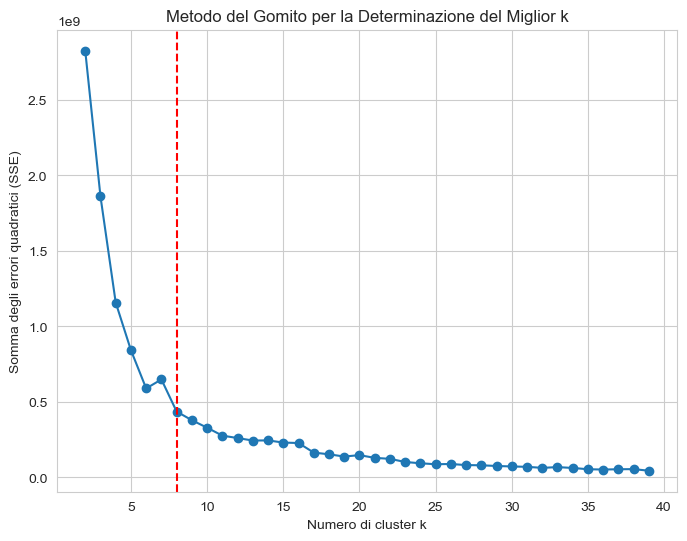

In [11]:
# VISUALIZZO LA CURVA SSE
plt.figure(figsize=(8, 6))
plt.plot(range(min_k, max_k), inertia, marker='o') 
plt.xlabel('Numero di cluster k')
plt.ylabel('Somma degli errori quadratici (SSE)')
plt.title('Metodo del Gomito per la Determinazione del Miglior k')

# Aggiungo una linea verticale per maggiore chiarezza visiva
plt.axvline(x=8, color='red', linestyle='--')
plt.savefig(images_path + 'elbow_curve.png')
plt.show()

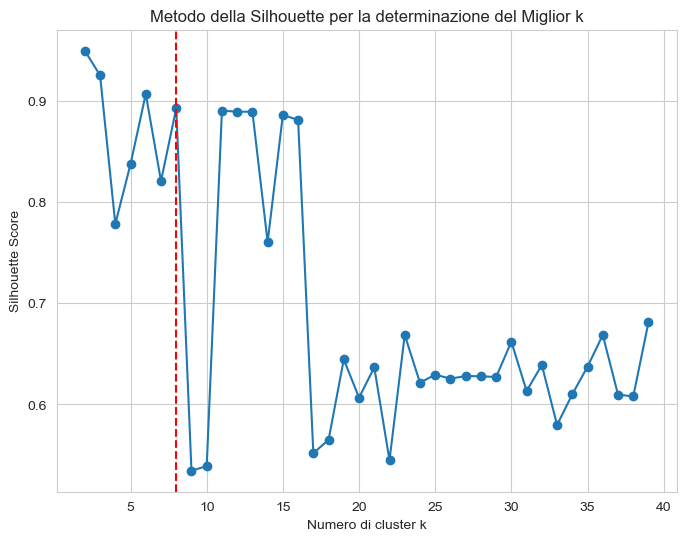

In [12]:
# VISUALIZZO LA CURVA SILHOUETTE
plt.figure(figsize=(8, 6))
plt.plot(range(min_k, max_k), silhouette_values, marker='o')
plt.xlabel('Numero di cluster k')
plt.ylabel('Silhouette Score')
plt.title('Metodo della Silhouette per la determinazione del Miglior k')

# Aggiungo una linea verticale per maggiore chiarezza visiva
plt.axvline(x=8, color='red', linestyle='--')
plt.savefig(images_path + 'silhouette_curve.png')
plt.show()

### K-MEANS ALGORITHM

In [13]:
# Preparazione dei dati per il clustering vero e proprio, ora che sappiamo quanto vale k
columns_for_clustering = ["latitude", "longitude"]
vecAssembler = VectorAssembler(inputCols=columns_for_clustering, outputCol="features")
df = vecAssembler.transform(df) 

# Eseguo il clustering con k-means
n_clusters = 8
kmeans = KMeans().setK(n_clusters).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df)
centers = model.clusterCenters()

# Printo i centri dei clusters calcolati con Spark
# per passarli alla mappa dei cluster ricavati con DBSCAN nel file facoltativo
print(centers) 

# Aggiunge a default una colonna 'prediction' contenente le etichette del clustering
df = model.transform(df)

[array([-31.95719502, -61.85525936]), array([40.99230324, 15.40251121]), array([  37.28307991, -118.80848352]), array([ 10.9549786, 144.8900533]), array([  60.51121901, -152.80354654]), array([  -7.2051918 , -168.06480095]), array([15.63399487, 84.00092998]), array([ 18.10370265, -76.10273271])]


In [14]:
df.show()

+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+--------------------+----------+
|                time|          latitude|          longitude|             depth| mag|magType|  gap|                dmin| rms|             updated|               place| nst|magNst|            features|prediction|
+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+--------------------+----------+
|1971-12-08 07:43:...|47.842833299999995|-119.62116670000002|             6.518| 1.6|     md|301.0|              0.4872|0.12|2016-07-25 01:51:...|          Washington| 7.0|   7.0|[47.8428332999999...|         2|
|1972-11-15 10:11:...|        46.8286667|           -119.473|1.3880000000000001| 0.9|     md|194.0|             0.03549|0.12|2016-07-25 01:57:...|      

In [15]:
# Seleziono le colonne da passare al dataframe Pandas
# il dataframe pandas conterrà un campione la cui frazione è scritta sotto
selected_df = df.select(*columns_for_clustering, "prediction")

# Creo un sample per la visualizzazione dei clusters prima di passare il dataframe a pandas:
# Questo codice crea un sample casuale senza rimpiazzo corrispondente al 30% del dataset originale
sampling_fraction = 0.3
sample_df_ = selected_df.sample(False, sampling_fraction)

# Converto il DataFrame Spark in un DataFrame Pandas
pandas_df = sample_df_.toPandas()

In [16]:
# Pandas dataframe contenente le etichette
pandas_df.head()

,latitude,longitude,prediction
0,47.842833,-119.621167,2
1,34.084833,-116.782333,2
2,46.441333,-119.279500,2
3,32.720000,-116.495833,2
4,46.685500,-119.242833,2


In [17]:
len(pandas_df)

782819

/Users/peppe212/anaconda3/envs/distributed_data_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/peppe212/anaconda3/envs/distributed_data_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/peppe212/anaconda3/envs/distributed_data_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/peppe212/anaconda3/envs/distributed_data_analysis/lib/python3.11/site-packages/seaborn/_oldcore.

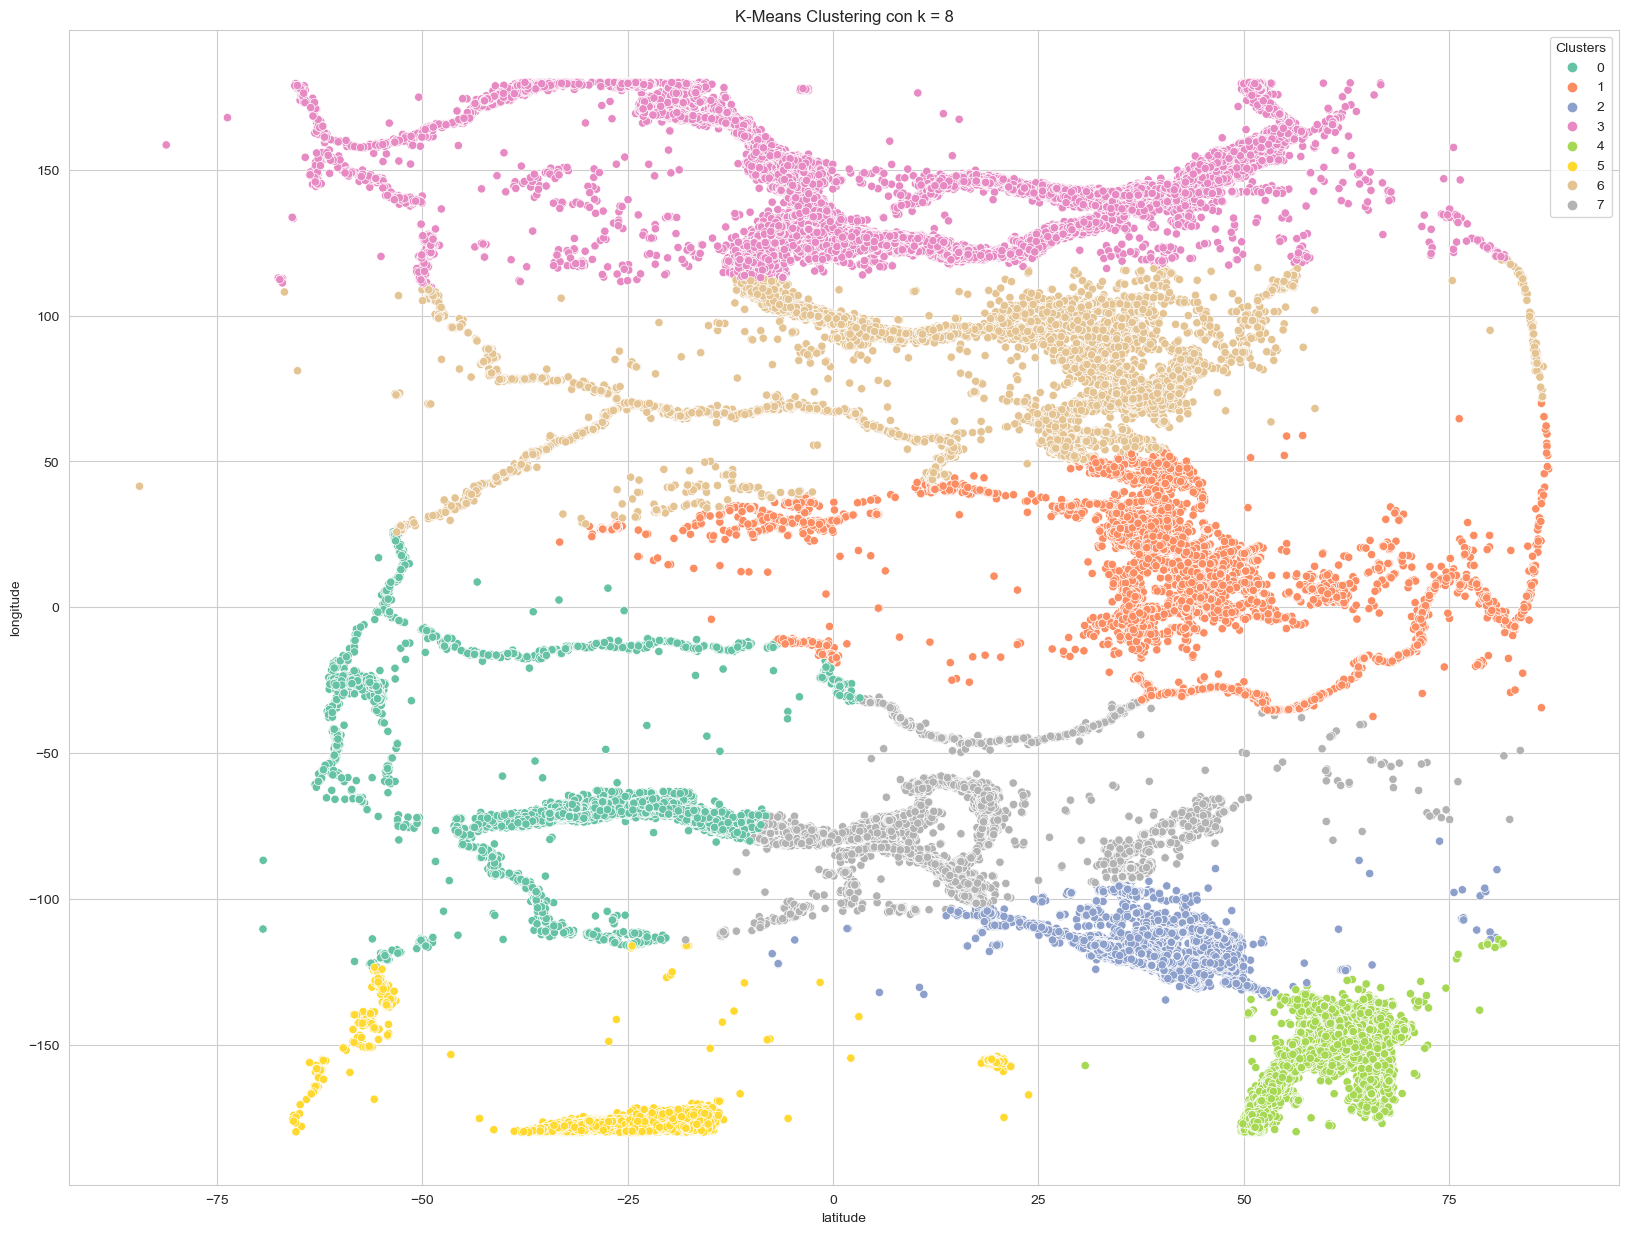

In [18]:
# Plottiamo il grafico usando una specifica palette seaborn che considereremo costante
palette = sns.color_palette("Set2", n_clusters)

plt.figure(figsize=(20, 15))
sns.scatterplot(data=pandas_df, x='latitude', y='longitude', hue='prediction', palette=palette)

plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title(f'K-Means Clustering con k = {n_clusters}')
plt.legend(title='Clusters')
plt.savefig(images_path + 'kmeans_clusters.png')
plt.show()

### WORLD MAP clustered

In [19]:
# CREIAMO UNA MAPPA FOLIUM SUL QUALE VEDERE I CLUSTERS E SOVRAPPOSTI I MARKERS DEI CENTROIDI CORRISPONDENTI
# Per capire il centroide a quale cluster appartiene è sufficiente cliccare sul marker
# mappa raffigurante i punti di latitudine e longitudine dei terremoti e i centri dei miei clusters trovati con kmeans

# conviene non procedere oltre questa soglia di righe
n_points_sample = 30000
sampled_df = pandas_df.sample(n=n_points_sample)

# Creo una mappa di base con zoom_start a 2 per vedere direttamente l'intera mappa mondiale
latitude_center = sampled_df['latitude'].mean()
longitude_center = sampled_df['longitude'].mean()
map_combined = folium.Map(location=[latitude_center, longitude_center], zoom_start=1)

# Aggiungo i centroidi dei cluster come marker rossi
for idx, center in enumerate(centers):
    folium.Marker(
        # L'assunzione è che center[0] corrisponde alla latitudine e center[1] alla longitudine
        location=[center[0], center[1]],
        icon=folium.Icon(color='red', icon='info-sign'),
        popup=f'Cluster Center: {idx}'  
    ).add_to(map_combined)

# Converto la palette di colori in formato esadecimale
colors_hex = [mcolors.to_hex(color) for color in palette]

# Aggiungo i punti di ogni cluster alla mappa
for idx, row in sampled_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=colors_hex[int(row['prediction']) % len(colors_hex)],
        fill=True,
        fill_color=colors_hex[int(row['prediction']) % len(colors_hex)],
        popup=f'Cluster: {row["prediction"]}'
    ).add_to(map_combined)

# Salvo la mappa come file .html
map_combined.save(images_path + 'world_map_combined.html')

In [ ]:
"""
qui visualizzavo la mappa del mondo con i clusters e i vari centroidi
la mappa è interattiva e cliccando sul centroide appare il cluster di riferimento
se la renderizzavo qui il file diventava di 40mb, ergo ho deciso di toglierla da qui
e per visualizzare la mappa basta cliccare sulla cartella images, clustering_kmeans e poi aprire
la mappa contenuta nel file .html
"""

In [21]:
# rinomino la colonna prediction del dataset spark in kmeans_labels
df = df.withColumnRenamed("prediction", "kmeans_labels")

# elimino dal dataframe la colonna features del vector assembler
df = df.drop('features')

In [22]:
# controllo che le modifiche abbiano effetto
df.show()

+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+-------------+
|                time|          latitude|          longitude|             depth| mag|magType|  gap|                dmin| rms|             updated|               place| nst|magNst|kmeans_labels|
+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+-------------+
|1971-12-08 07:43:...|47.842833299999995|-119.62116670000002|             6.518| 1.6|     md|301.0|              0.4872|0.12|2016-07-25 01:51:...|          Washington| 7.0|   7.0|            2|
|1972-11-15 10:11:...|        46.8286667|           -119.473|1.3880000000000001| 0.9|     md|194.0|             0.03549|0.12|2016-07-25 01:57:...|          Washington| 8.0|   8.0|            2|
|1972-11-21 10:27:...|        

In [23]:
df.printSchema()

root
 |-- time: timestamp (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- depth: double (nullable = true)
 |-- mag: double (nullable = true)
 |-- magType: string (nullable = true)
 |-- gap: double (nullable = true)
 |-- dmin: double (nullable = true)
 |-- rms: double (nullable = true)
 |-- updated: timestamp (nullable = true)
 |-- place: string (nullable = true)
 |-- nst: double (nullable = true)
 |-- magNst: double (nullable = true)
 |-- kmeans_labels: integer (nullable = false)


In [25]:
# iniziamo col calcolare quanti terremoti in generale sono contenuti in ogni clusters e le loro percentuali
from pyspark.sql.functions import col, count, lit

# Calcola il conteggio totale dei punti
total_count = df.count()

# Raggruppa per 'kmeans_labels' e conta i punti in ogni cluster
cluster_counts = df.groupBy('kmeans_labels').agg(count(lit(1)).alias('count'))

# Calcola la percentuale di ciascun cluster
cluster_percentages = cluster_counts.withColumn('percentage', (col('count') / total_count) * 100)

# Ordina i risultati per label del cluster
cluster_percentages = cluster_percentages.orderBy('kmeans_labels')

# Mostra i risultati
cluster_percentages.show()


+-------------+-------+------------------+
|kmeans_labels|  count|        percentage|
+-------------+-------+------------------+
|            0|  39431|1.5121637313870138|
|            1|  81175| 3.113030125924801|
|            2|1655188| 63.47582516869996|
|            3| 185497| 7.113738826839209|
|            4| 469751| 18.01477073832216|
|            5|  59550| 2.283719667370766|
|            6|  57051|2.1878839755360127|
|            7|  59945|2.2988677659200762|
+-------------+-------+------------------+


'\nNel cluster 2 sono concentrati la stragrande maggioranza dei terremoti registrati\n'

In [28]:
"""
# salvo il dataframe spark contenente le etichette del clustering effettuato dal k-means
df.coalesce(1).write.format("csv") \
    .option("header", "true") \
    .mode("overwrite") \
    .option("sep", ",") \
    .save(output_dataset_path)
"""

In [29]:
# chiudo la sessione spark e rilascio le risorse
spark.stop()